In [5]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from tqdm.notebook import tqdm, trange

%matplotlib inline

## Конфигурация

In [6]:
config = dict(
    n_epochs=5,
    batch_size=128,
    learning_rate=0.0005,
    hidden_to_input_ratio=2
)

## Dataset

In [7]:
class TrackLikelihoodDataset(torch.utils.data.Dataset):

    def __init__(self, path, x_file='x.pt', y_file='y.pt'):
        self.x = torch.load(path + '/' + x_file)
        self.y = torch.load(path + '/' + y_file)
        
        if len(self.x) != len(self.y):
            raise RuntimeError(f'Tensors X and Y must be of the same size.')

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Нейронная сеть

In [8]:
class TrackLikelihoodNetwork(torch.nn.Module):

    def __init__(self, input_size, hidden_to_input_ratio=1):
        super(TrackLikelihoodNetwork, self).__init__()

        self.input_size = input_size
        self.hidden_size = int(input_size * hidden_to_input_ratio)
        self.output_size = 1

        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, self.hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(self.hidden_size, self.output_size),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.fc_layers(x)

## Обучение нейросети

#### Подготовка Dataset и DataLoader

In [9]:
train_dataset = TrackLikelihoodDataset(path='TL_data/train')

In [26]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               shuffle=True,
                                               batch_size=config['batch_size'])

#### Обучение

In [27]:
model = TrackLikelihoodNetwork(input_size=train_dataset[0][0].shape[0],
                               hidden_to_input_ratio=config['hidden_to_input_ratio'])
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [28]:
loss_history = []
lr_history = []

epoch_progress = trange(config['n_epochs'])
for epoch in epoch_progress:
    epoch_progress.set_description(f'Epoch {epoch + 1}')

    for i, (x, y) in enumerate(train_dataloader):
        out = model(x)
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        lr_history.append(optimizer.param_groups[0]['lr'])
        loss_history.append(loss.item())
        
        epoch_progress.set_postfix({'loss': loss.item()})

    # optimizer.param_groups[0]['lr'] *= 0.1

  0%|          | 0/5 [00:00<?, ?it/s]

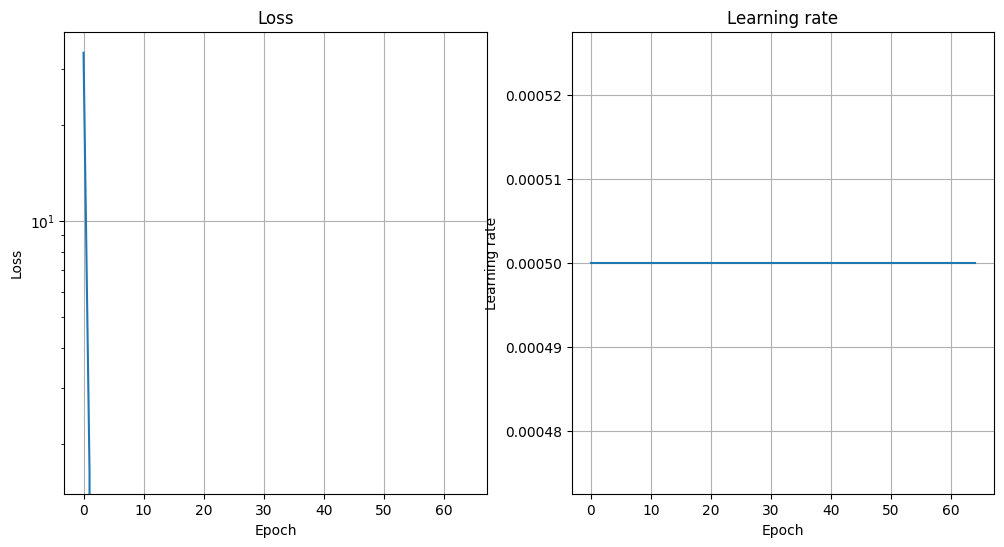

In [29]:
fig, axis = plt.subplots(1, 2, figsize=(12, 6))

# Loss plot
axis[0].set_title('Loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')
axis[0].semilogy()
axis[0].grid()
axis[0].plot(loss_history)

# Learning rate plot
axis[1].set_title('Learning rate')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Learning rate')
axis[1].grid()
axis[1].plot(lr_history)

## Тестирование нейросети

#### Подготовка Dataset и DataLoader для тестирования

In [30]:
test_dataset = TrackLikelihoodDataset(path='TL_data/test')

FileNotFoundError: [Errno 2] No such file or directory: 'TL_data/test/x.pt'

In [ ]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=config['batch_size'])

#### Расчет метрик

In [ ]:
losses = []

for i, (x, y) in enumerate(test_dataloader):
    with torch.inference_mode():
        out = model(x)
        loss = criterion(out, y)
        losses.append(loss.item())

print(f'Loss on test = {np.mean(losses)}')